In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Dataset Loader

In [2]:
class L96Dataset(Dataset):
    def __init__(self, csv_file, data_dir, ids, scaler=None):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df['id'].isin(ids)]
        self.data_dir = data_dir
        self.scaler = scaler

        self.inputs, self.targets = [], []
        for _, row in self.df.iterrows():
            id_str = row['id']
            F = row['F']
            target = row['E_time_mean']
            # load x0 vector
            x0_path = os.path.join(data_dir, f"x0_{int(id_str):07d}.npy")
            x0 = np.load(x0_path)
            x = np.concatenate([[F], x0])  # shape (41,)
            self.inputs.append(x)
            self.targets.append(target)

        self.inputs = np.array(self.inputs, dtype=np.float32)
        self.targets = np.array(self.targets, dtype=np.float32).reshape(-1, 1)

        # Scale inputs if scaler provided
        if self.scaler:
            self.inputs = self.scaler.transform(self.inputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx]), torch.tensor(self.targets[idx])

### NN Architecture

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # scalar output
        )

    def forward(self, x):
        return self.net(x)

### Training

In [4]:
def train_model(model, train_loader, val_loader, epochs=100, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    all_train_losses = []
    all_val_losses = []

    for epoch in range(epochs):
        # ----- Training -----
        model.train()
        epoch_train_losses = []
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(X)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
        mean_train_loss = np.mean(epoch_train_losses)

        # ----- Validation -----
        model.eval()
        epoch_val_losses = []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                preds = model(X)
                loss = criterion(preds, y)
                epoch_val_losses.append(loss.item())
        mean_val_loss = np.mean(epoch_val_losses)

        # Save losses
        all_train_losses.append(mean_train_loss)
        all_val_losses.append(mean_val_loss)

        # Progress log
        print(f"Epoch {epoch+1}/{epochs} "
              f"Train Loss: {mean_train_loss:.4f} "
              f"Val Loss: {mean_val_loss:.4f}")

    return model, all_train_losses, all_val_losses


In [5]:
data_dir = "data/l96_N40_T20_S600_1000"
csv_file = os.path.join(data_dir, "targets_time_mean_energy.csv")

# Read all IDs
df = pd.read_csv(csv_file)
ids = df['id'].tolist()

# Train/val/test split
train_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.176, random_state=42)  # 0.176*0.85 ≈ 0.15

# Fit scaler on training inputs
all_inputs = []
for id_str in train_ids:
    row = df[df['id'] == id_str].iloc[0]
    F = row['F']
    x0 = np.load(os.path.join(data_dir, f"x0_{int(id_str):07d}.npy"))
    all_inputs.append(np.concatenate([[F], x0]))
scaler = StandardScaler().fit(np.array(all_inputs, dtype=np.float32))

# Create datasets
train_ds = L96Dataset(csv_file, data_dir, train_ids, scaler)
val_ds = L96Dataset(csv_file, data_dir, val_ids, scaler)
test_ds = L96Dataset(csv_file, data_dir, test_ids, scaler)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# Initialize model
model = SimpleNN(input_dim=41)

# Train
_, all_train_losses, all_val_losses = train_model(model, train_loader, val_loader, epochs=500, lr=1e-3)

# Evaluate on test set
model.eval()
preds, trues = [], []
with torch.no_grad():
    for X, y in test_loader:
        preds.append(model(X).numpy())
        trues.append(y.numpy())

preds = np.vstack(preds)
trues = np.vstack(trues)

Epoch 1/500 Train Loss: 408229.6282 Val Loss: 370319.1609
Epoch 2/500 Train Loss: 381096.5696 Val Loss: 320463.6094
Epoch 3/500 Train Loss: 288889.6531 Val Loss: 203019.2391
Epoch 4/500 Train Loss: 153050.1042 Val Loss: 97618.9531
Epoch 5/500 Train Loss: 81110.4497 Val Loss: 74108.7297
Epoch 6/500 Train Loss: 73152.4728 Val Loss: 72669.8852
Epoch 7/500 Train Loss: 72452.0139 Val Loss: 71933.2859
Epoch 8/500 Train Loss: 71512.9416 Val Loss: 71490.9961
Epoch 9/500 Train Loss: 70670.0264 Val Loss: 70659.6871
Epoch 10/500 Train Loss: 69978.8715 Val Loss: 69858.8914
Epoch 11/500 Train Loss: 68890.6935 Val Loss: 69030.6691
Epoch 12/500 Train Loss: 67759.8767 Val Loss: 67874.1660
Epoch 13/500 Train Loss: 66566.7758 Val Loss: 67195.9297
Epoch 14/500 Train Loss: 65451.7614 Val Loss: 65599.0691
Epoch 15/500 Train Loss: 64365.8696 Val Loss: 64311.6746
Epoch 16/500 Train Loss: 61860.7953 Val Loss: 62810.9738
Epoch 17/500 Train Loss: 60205.3846 Val Loss: 60883.0691
Epoch 18/500 Train Loss: 58084.41

In [6]:
mse = mean_squared_error(trues, preds)
print(f"\nTest MSE: {mse:.4f}")


Test MSE: 251.6734


In [7]:
r2 = r2_score(trues, preds)
print(f"Test R²: {r2:.4f}")

Test R²: 0.9963


In [8]:
# Baseline: mean predictor
mean_pred = np.mean(trues)
mse_baseline = mean_squared_error(trues, np.full_like(trues, mean_pred))
print(f"Baseline MSE (mean predictor): {mse_baseline:.4f}")

Baseline MSE (mean predictor): 68885.5469


### Visualization

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

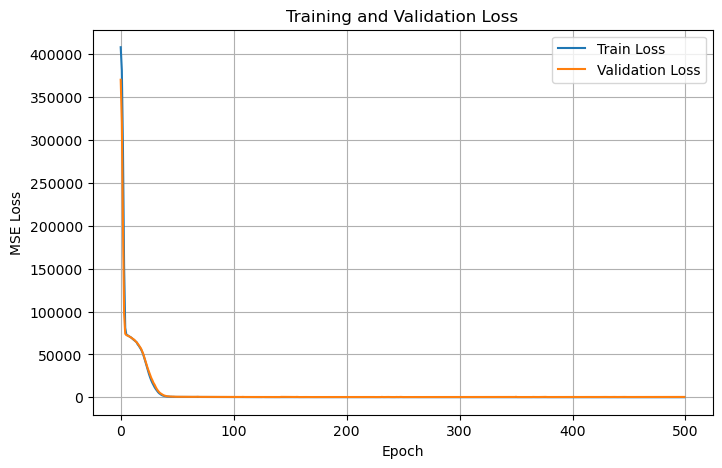

In [10]:
def plot_loss_curves(train_losses, val_losses):
    """Plot training and validation loss curves."""
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curves.png")
    plt.show()

plot_loss_curves(all_train_losses, all_val_losses)

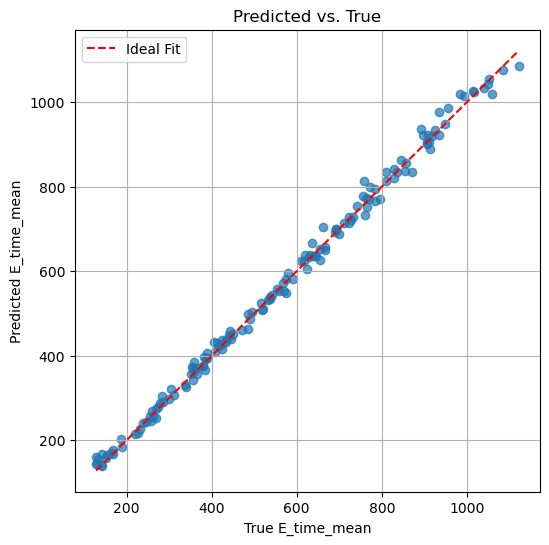

In [11]:
def plot_predictions_vs_true(y_true, y_pred):
    """Scatter plot: predicted vs. true values."""
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.7)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal Fit")
    plt.xlabel("True E_time_mean")
    plt.ylabel("Predicted E_time_mean")
    plt.title("Predicted vs. True")
    plt.legend()
    plt.grid(True)
    plt.savefig("preds_vs_true.png")
    plt.show()

plot_predictions_vs_true(trues, preds)

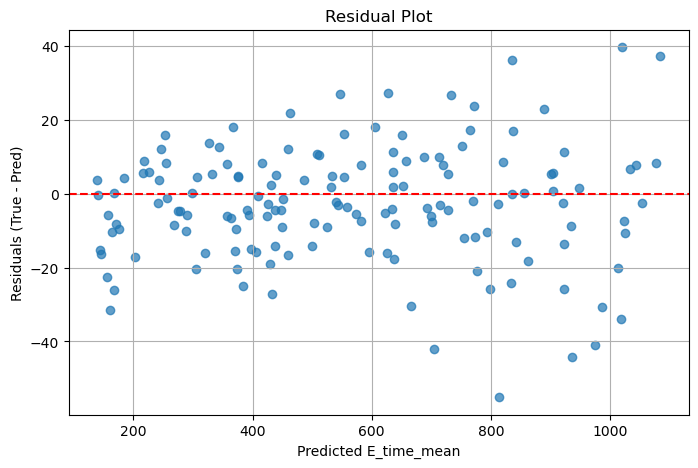

In [12]:
def plot_residuals(y_true, y_pred):
    """Residual plot: y_true - y_pred vs predicted."""
    residuals = y_true - y_pred
    plt.figure(figsize=(8,5))
    plt.scatter(y_pred, residuals, alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted E_time_mean")
    plt.ylabel("Residuals (True - Pred)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.savefig("residuals.png")
    plt.show()

plot_residuals(trues, preds)

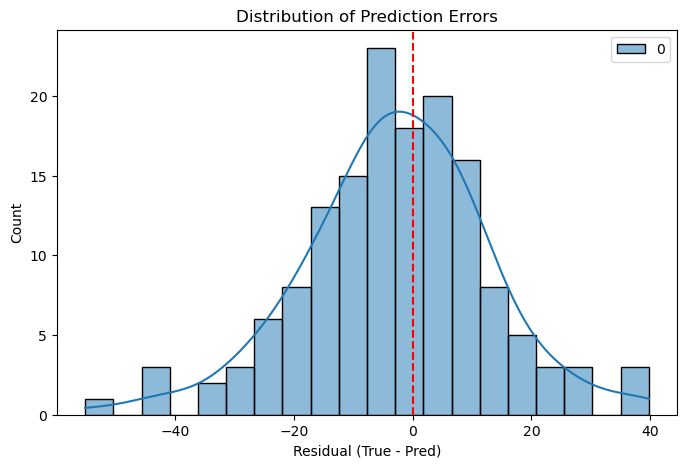

In [13]:
def plot_error_distribution(y_true, y_pred):
    """Histogram of residuals (errors)."""
    residuals = y_true - y_pred
    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, bins=20)
    plt.axvline(0, color="red", linestyle="--")
    plt.xlabel("Residual (True - Pred)")
    plt.ylabel("Count")
    plt.title("Distribution of Prediction Errors")
    plt.savefig("error_distribution.png")
    plt.show()

plot_error_distribution(trues, preds)

ValueError: x and y must be the same size

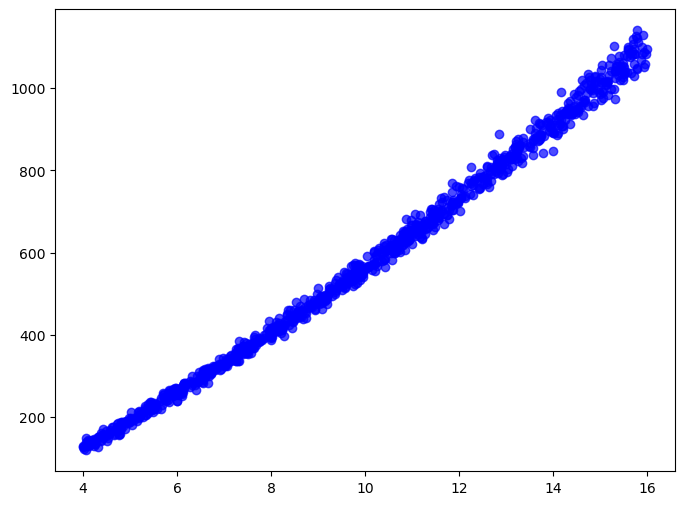

In [18]:
def plot_predictions_vs_F(df, preds, save_path=None):
    """
    Plot E_time_mean (true and predicted) against forcing F.
    
    Args:
        df (pd.DataFrame): dataframe with columns ['F', 'E_time_mean']
        preds (array-like): predicted E_time_mean, same length as df
        save_path (str, optional): if given, save the figure to this path
    """
    F = df['F'].values
    true_y = df['E_time_mean'].values
    preds = np.array(preds)

    plt.figure(figsize=(8,6))
    plt.scatter(F, true_y, label="True", alpha=0.7, color="blue")
    plt.scatter(F, preds, label="Predicted", alpha=0.7, color="red", marker="x")

    # Optional: connect each true vs pred with a line to visualize error
    for f, t, p in zip(F, true_y, preds):
        plt.plot([f, f], [t, p], color="gray", alpha=0.3, linewidth=0.8)

    plt.xlabel("Forcing (F)")
    plt.ylabel("E_time_mean")
    plt.title("True vs Predicted E_time_mean across Forcing F")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

plot_predictions_vs_F(df, preds)